In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [6]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [7]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """Parse Slack data to extract useful information from JSON files."""

    # Get all JSON file paths in the specified directory
    json_files = glob.glob(f"{path_channel}/*/*.json")

    # Initialize lists to store extracted data
    all_data = {
        'msg_type': [], 'msg_content': [], 'sender_name': [],
        'msg_sent_time': [], 'msg_dist_type': [], 'time_thread_start': [],
        'reply_count': [], 'reply_users_count': [], 'reply_users': [],
        'tm_thread_end': [], 'channel': []
    }

    # Loop through each JSON file path
    for file_path in json_files:
        with open(file_path, 'r', encoding="utf8") as file:
            json_data = json.load(file)

            for row in json_data:
                all_data['msg_type'].append(row.get('type', ''))
                all_data['msg_content'].append(row.get('text', ''))
                all_data['sender_name'].append(row.get('user_profile', {}).get('real_name', 'Not provided'))
                all_data['msg_sent_time'].append(row.get('ts', ''))
                if 'blocks' in row and row['blocks']:
                    block = row['blocks'][0]
                    if 'elements' in block and block['elements']:
                        element = block['elements'][0]
                        if 'elements' in element and element['elements']:
                            all_data['msg_dist_type'].append(element['elements'][0].get('type', 'reshared'))
                        else:
                            all_data['msg_dist_type'].append('reshared')
                    else:
                        all_data['msg_dist_type'].append('reshared')
                else:
                    all_data['msg_dist_type'].append('reshared')
                all_data['time_thread_start'].append(row.get('thread_ts', 0))
                all_data['reply_users'].append(",".join(row.get('reply_users', [])))
                all_data['reply_count'].append(row.get('reply_count', 0))
                all_data['reply_users_count'].append(row.get('reply_users_count', 0))
                all_data['tm_thread_end'].append(row.get('latest_reply', 0))
                all_data['channel'].append(file_path.split('/')[-2])  # Extract channel from file path

    # Create DataFrame from the extracted data
    df = pd.DataFrame(all_data)
    df = df[df['sender_name'] != 'Not provided'].reset_index(drop=True)
    
    return df


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [8]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [12]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

# def draw_user_reaction(data, channel='General'):
#     data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
#         .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
#     plt.title(f'User with the most reaction in #{channel}', size=25);
#     plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
#     plt.xticks(size=14); plt.yticks(size=14);
#     plt.show()

def draw_user_reaction(data):
    """Visualize reply counts per user per channel."""
    data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Reply Counts per User per Channel', fontsize=16)
    plt.xlabel('Channel', fontsize=14)
    plt.ylabel('Reply Count', fontsize=14)
    plt.legend(title='Sender Name', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [13]:
# which user has the highest number of reply counts?
# Parse Slack data
path_channel = '/home/biniyam/tenx-tasks/tenxdata/'
parsed_data = slack_parser(path_channel)

# Find the user with the highest reply count
user_with_highest_replies = parsed_data['reply_count'].idxmax()
highest_reply_count = parsed_data.loc[user_with_highest_replies, 'reply_count']
sender_name = parsed_data.loc[user_with_highest_replies, 'sender_name']

print(f"The user with the highest number of reply counts is: {sender_name} with {highest_reply_count} replies.")

The user with the highest number of reply counts is: Brian Odom with 75 replies.


/tmp/ipykernel_6053/3010717355.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


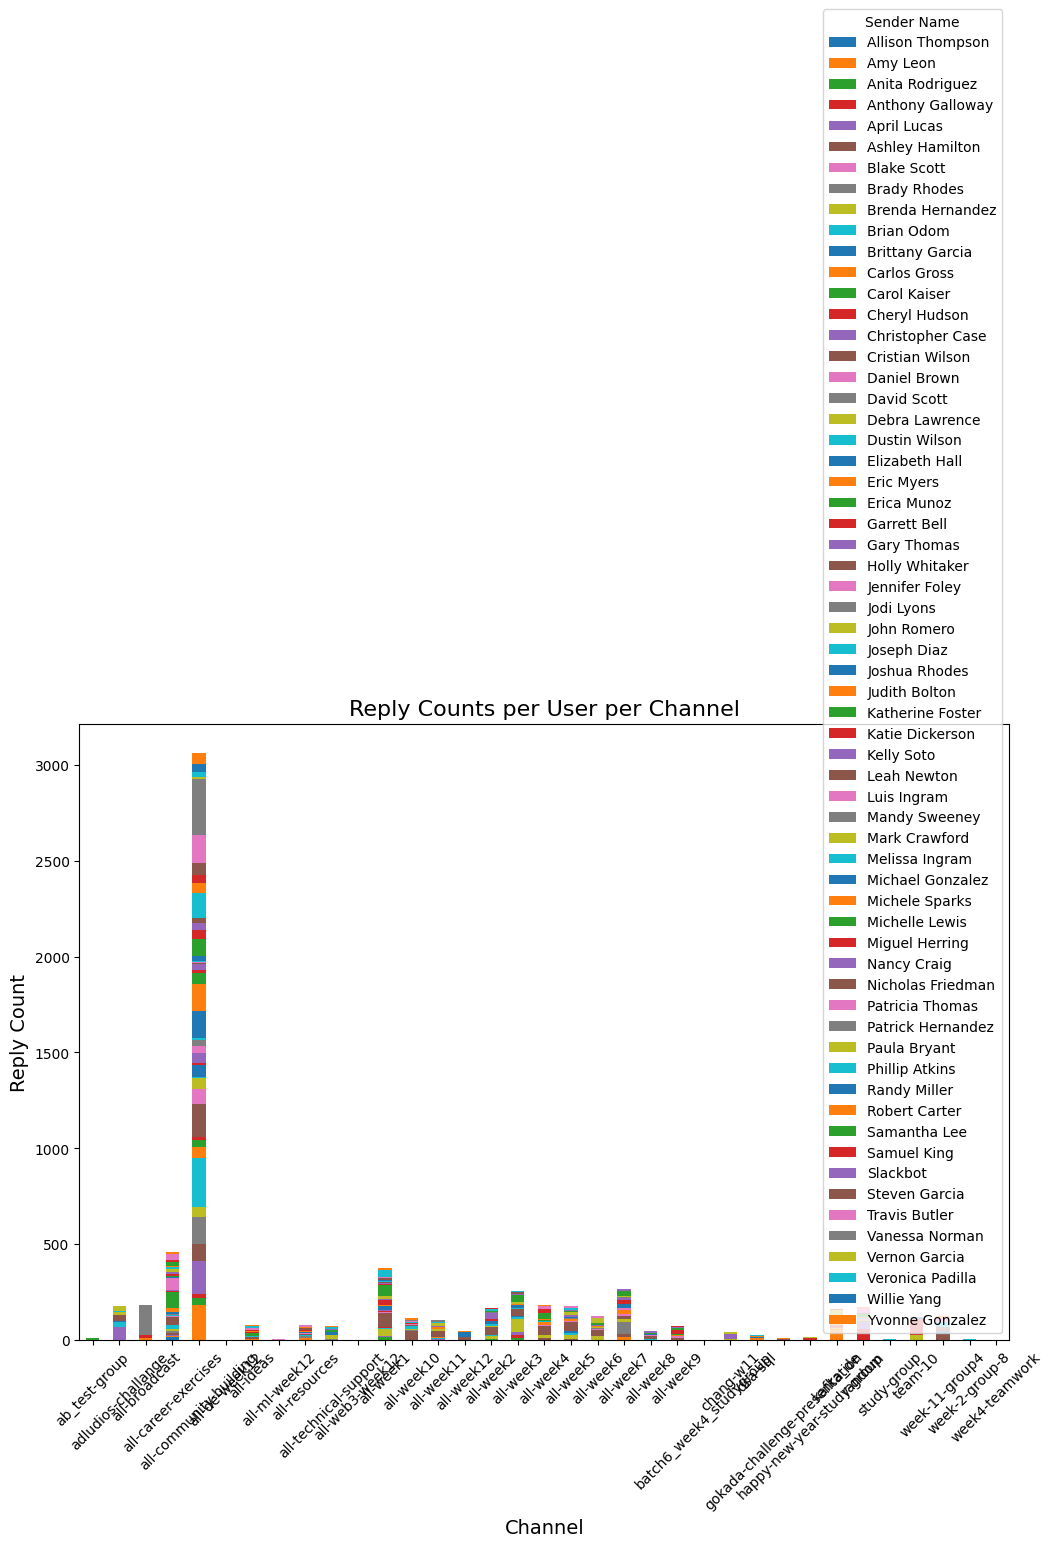

In [14]:
# Visualize reply counts per user per channel
draw_user_reaction(parsed_data)

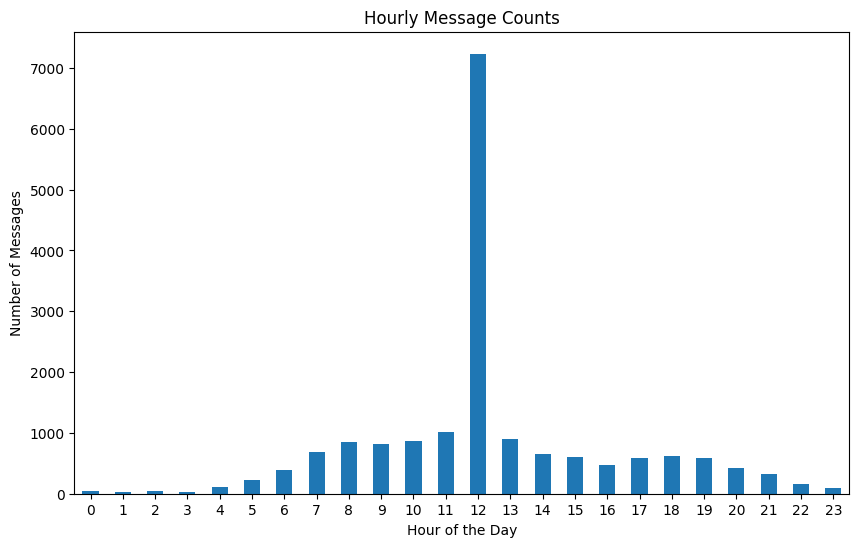

The hour with the most messages is 12:00 with 7233 messages.


In [41]:
# Convert 'msg_sent_time' column to datetime format
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s')

# Extract hour from message timestamps
parsed_data['hour_sent'] = parsed_data['msg_sent_time'].dt.hour

# Group messages by hour and count the number of messages in each hour
hourly_message_count = parsed_data.groupby('hour_sent').size()

# Find the hour with the maximum number of messages
hour_peak = hourly_message_count.idxmax()
max_messages = hourly_message_count.max()

# Visualize hourly message counts
hourly_message_count.plot(kind='bar', figsize=(10, 6))
plt.title('Hourly Message Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.show()

print(f"The hour with the most messages is {hour_peak}:00 with {max_messages} messages.")

In [45]:
# what kind of messages are replied faster than others?
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'])
parsed_data['time_thread_start'] = pd.to_datetime(parsed_data['time_thread_start'])

parsed_data['response_time'] = parsed_data['time_thread_start'] - parsed_data['msg_sent_time']

# Group messages by their types and calculate the average response time for each type
average_response_time_by_type = parsed_data.groupby('msg_type')['response_time'].mean()

# Sort average response times in ascending order
sorted_response_times = average_response_time_by_type.sort_values()

# Display the average response times for each message type
print("Average response times for each message type:")
print(sorted_response_times)

# Visualize the average response times
sorted_response_times.plot(kind='bar', figsize=(10, 6))
plt.title('Average Response Time by Message Type')
plt.xlabel('Message Type')
plt.ylabel('Average Response Time')
plt.xticks(rotation=45)
plt.show()

TypeError: invalid string coercion to datetime for "1661845812.720709" at position 1

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?